In [1]:
#### from pytorch_grad_cam import GradCAM
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score
import pickle
from collections import defaultdict
from sklearn.utils import shuffle

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import random
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, auc, average_precision_score
import matplotlib.pyplot as plt
from torcheval.metrics.functional import multilabel_auprc
from sklearn.preprocessing import label_binarize


# Load the data from pickle files
def load_pickle(path):
    with open(path, 'rb') as file:
        return pickle.load(file)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda')

<h1> DATA MANIPULATION

In [3]:
import numpy as np
import os

# Define the folder path
folder_path = r"D:\PYTHONIG\newwindow\numpy\ORIGINAL DATA\MEL"

# Load the numpy files into the respective arrays
eeg_fold_1 = np.load(os.path.join(folder_path, 'eeg_fold_1.npy'))
labels_fold_1 = np.load(os.path.join(folder_path, 'labels_fold_1.npy'))
patients_fold_1 = np.load(os.path.join(folder_path, 'patients_fold_1.npy'))

eeg_fold_2 = np.load(os.path.join(folder_path, 'eeg_fold_2.npy'))
labels_fold_2 = np.load(os.path.join(folder_path, 'labels_fold_2.npy'))
patients_fold_2 = np.load(os.path.join(folder_path, 'patients_fold_2.npy'))

eeg_fold_3 = np.load(os.path.join(folder_path, 'eeg_fold_3.npy'))
labels_fold_3 = np.load(os.path.join(folder_path, 'labels_fold_3.npy'))
patients_fold_3 = np.load(os.path.join(folder_path, 'patients_fold_3.npy'))

eeg_fold_4 = np.load(os.path.join(folder_path, 'eeg_fold_4.npy'))
labels_fold_4 = np.load(os.path.join(folder_path, 'labels_fold_4.npy'))
patients_fold_4 = np.load(os.path.join(folder_path, 'patients_fold_4.npy'))

eeg_fold_5 = np.load(os.path.join(folder_path, 'eeg_fold_5.npy'))
labels_fold_5 = np.load(os.path.join(folder_path, 'labels_fold_5.npy'))
patients_fold_5 = np.load(os.path.join(folder_path, 'patients_fold_5.npy'))


In [4]:
for i in range (len(labels_fold_1)):
    if (labels_fold_1[i] == 2):
        labels_fold_1[i] = 1

for i in range (len(labels_fold_2)):
    if (labels_fold_2[i] == 2):
        labels_fold_2[i] = 1

for i in range (len(labels_fold_3)):
    if (labels_fold_3[i] == 2):
        labels_fold_3[i] = 1

for i in range (len(labels_fold_4)):
    if (labels_fold_4[i] == 2):
        labels_fold_4[i] = 1

for i in range (len(labels_fold_5)):
    if (labels_fold_5[i] == 2):
        labels_fold_5[i] = 1
        
#eeg folds        
eeg_folds = [eeg_fold_1, eeg_fold_2, eeg_fold_3, eeg_fold_4, eeg_fold_5]

#d l p
d = np.concatenate(eeg_folds)

labels_folds = [labels_fold_1, labels_fold_2, labels_fold_3, labels_fold_4, labels_fold_5]
l = np.concatenate(labels_folds)

patients_folds = [patients_fold_1, patients_fold_2, patients_fold_3, patients_fold_4, patients_fold_5]
p = np.concatenate(patients_folds)

d.shape,l.shape,p.shape

((4755, 100, 100, 20), (4755,), (4755,))

<h1> utils

In [5]:
class EarlyStopping:
    def __init__(self, patience=5):
        """
        Initializes the early stopping mechanism based on divergence detection.

        Args:
            patience (int): Number of consecutive epochs with increasing validation loss
                            before stopping.
        """
        self.patience = patience
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        """
        Checks if the validation loss is diverging and updates the state accordingly.

        Args:
            val_loss (float): Current epoch's validation loss.
            model (torch.nn.Module): The model being trained.
        """
        if self.best_loss is None or val_loss < self.best_loss:
            # Improvement detected
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            # Validation loss increased
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Divergence detected. Stopping training after {self.counter} epochs.")
                self.early_stop = True

    def load_best_model(self, model):
        """
        Restores the model to the state with the lowest validation loss.

        Args:
            model (torch.nn.Module): The model to restore.
        """
        model.load_state_dict(self.best_model_state)




<h1>MODEL

In [6]:
# def patchify(data, n_patches):
#     n, c, h, w = data.shape
#     patches = torch.zeros(n, n_patches**2, (c*h*w) // (n_patches**2))
#     patch_size = h // n_patches
#     for idx, d in enumerate(data):
#         for i in range(n_patches):
#             for j in range(n_patches):
#                 patch = d[:, i*patch_size: (i+1)*patch_size, j*patch_size: (j+1) * patch_size]
#                 patches[idx, i*n_patches + j] = patch.flatten()

#     return patches


# def get_positional_embeddings(sequence_length, d):
#     result = torch.ones(sequence_length, d)
#     for i in range(sequence_length):
#         for j in range(d):
#             result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
#     return result
    
# class vit(nn.Module):
#     def __init__(self, input_size, n_patches, hidden_size):
#         super().__init__()
#         self.chw = input_size
#         self.n_patches = n_patches
#         self.patch_size = ((self.chw[1] // n_patches) ** 2) * self.chw[0]
#         self.linear_mapper = nn.Linear(self.patch_size, hidden_size)
#         self.class_token = nn.Parameter(torch.rand(1, hidden_size))
#         self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches ** 2 + 1, hidden_size)))
#         self.pos_embed.requires_grad = True
#         self.layer_norm = nn.LayerNorm(hidden_size)

#         # Transformer encoder layers
#         self.encoder_layers = nn.ModuleList([
#             nn.TransformerEncoderLayer(d_model=hidden_size, nhead=4, batch_first=True)
#             for _ in range(2)
#         ])
#         self.classifier = nn.Sequential(    
#             nn.Linear(hidden_size, 2))

#         # Grad-CAM hooks
#         self.gradients = None
#         self.activations = None

#     def save_gradients(self, grad):
#         self.gradients = grad
#         # print("Stored gradients:", self.gradients)
        
#     def forward(self, x):
#         patches = patchify(x, self.n_patches)
#         # print("Shape after patchify:", patches.shape)
     
#         x = self.linear_mapper(patches.to(device))
#         # print(f"x after linear_mapper: {x.shape}")
#         x = torch.stack([torch.vstack((self.class_token, x[i])) for i in range(len(x))])
#         # print(f"x after adding class token: {x.shape}")
#         pos_embed = self.pos_embed.repeat(len(x), 1, 1)
#         x = x + pos_embed
#         x = self.layer_norm(x)

#         # Pass through transformer encoder layers
#         for idx, layer in enumerate(self.encoder_layers):
#             if idx == len(self.encoder_layers) - 1:
#                 x = layer(x)
#                 x.requires_grad_() # Focus on the last encoder layer
                
#                 x.register_hook(self.save_gradients)  # Save gradients
#                 self.activations = x  # Save activations
#             else:
#                 x = layer(x)

#         x = x[:, 0]  # CLS token
#         x = self.classifier(x)
#         return x


<h1> UPDATED MODEL

In [7]:
import torch
import torch.nn as nn
import numpy as np

def patchify(data, n_patches):
    n, c, h, w = data.shape
    patches = torch.zeros(n, n_patches**2, (c*h*w) // (n_patches**2))
    patch_size = h // n_patches
    for idx, d in enumerate(data):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = d[:, i*patch_size: (i+1)*patch_size, j*patch_size: (j+1) * patch_size]
                patches[idx, i*n_patches + j] = patch.flatten()
    return patches

def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

class vit(nn.Module):
    def __init__(self, input_size, n_patches, hidden_size):
        super().__init__()
        self.chw = input_size
        self.n_patches = n_patches
        self.patch_size = ((self.chw[1] // n_patches) ** 2) * self.chw[0]
        self.linear_mapper = nn.Linear(self.patch_size, hidden_size)
        self.class_token = nn.Parameter(torch.rand(1, hidden_size))
        self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches ** 2 + 1, hidden_size)))
        self.pos_embed.requires_grad = True
        self.layer_norm = nn.LayerNorm(hidden_size)

        # Transformer encoder layers
        self.encoder_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=hidden_size, nhead=4, batch_first=True)
            for _ in range(2)
        ])
        self.classifier = nn.Sequential(nn.Linear(hidden_size, 2))

        # For saliency maps
        self.gradients = None
        self.activations = None
        self._register_hook = False

    def save_gradient(self, grad):
        self.gradients = grad

    def forward(self, x):
        patches = patchify(x, self.n_patches)
        
        x = self.linear_mapper(patches)
        x = torch.stack([torch.vstack((self.class_token, x[i])) for i in range(len(x))])
        pos_embed = self.pos_embed.repeat(len(x), 1, 1)
        x = x + pos_embed
        x = self.layer_norm(x)

        # Pass through transformer encoder layers
        for idx, layer in enumerate(self.encoder_layers):
            x = layer(x)
            if idx == len(self.encoder_layers) - 1 and not self._register_hook:
                x.register_hook(self.save_gradient)  # Register hook only once
                self._register_hook = True
            self.activations = x  # Save the latest activations

        x = x[:, 0]  # Select CLS token for classification
        x = self.classifier(x)
        return x

    def get_activations_gradient(self):
        return self.gradients

    def get_activations(self):
        return self.activations

    def set_hook(self, hook_status):
        self._register_hook = hook_status

<h1> LOADING MODEL

In [8]:
def load_model(model_path, model_class, device):
    model = model_class((20, 100, 100), 10, 256).to(device)  
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['MEL_model_state_dict'])
    model.eval()
    return model


In [9]:
path = r"D:\PYTHONIG\newwindow\SALIENCY\model_fold_1_1P.pth"
model = load_model(model_path=path, model_class=vit, device=device)

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_26876\2463100829.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches ** 2 + 1, hidden_size)))


In [11]:
device = torch.device('cpu')

<h1> SALIENCY, TWITTER GROK- CHATGPT- BARD- GITHUB REPO- SELF MODIFIED

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def saliency(img, model):
    # Disable gradient computation for model parameters since we're only interested in input gradients
    for param in model.parameters():
        param.requires_grad = False
    
    model.eval() 
    input = img.unsqueeze(0)  
    input.requires_grad_(True)

    preds = model(input)
    score, _ = torch.max(preds, 1)
    
    score.backward()
    
    saliency_map = torch.abs(input.grad[0].sum(dim=0))  
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())  # Normalize
    
    # Convert to numpy for plotting
    saliency_map_np = saliency_map.detach().cpu().numpy()
    
    with torch.no_grad():
        original_img = input[0].cpu().numpy()
        original_img = np.transpose(original_img, (1, 2, 0))  # [C, H, W] to [H, W, C]
    
    average_image = np.mean(original_img, axis=2)
    # Plotting
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(average_image)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(saliency_map_np, cmap='hot')
    plt.title("Saliency Map")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


<h1> GETTING SAME TEST DATA USED IN FOLD 1 MODEL

In [32]:
test_data = eeg_folds[4]
test_data= np.transpose(test_data, (0,3,1,2))

test_data_tensor = torch.tensor(test_data, dtype=torch.float32).to(device)
test_labels_tensor = torch.tensor(labels_folds[4], dtype=torch.long).to(device)
# test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)
# test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [49]:
model.to(device)

vit(
  (linear_mapper): Linear(in_features=2000, out_features=256, bias=True)
  (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (encoder_layers): ModuleList(
    (0-1): 2 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (linear1): Linear(in_features=256, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=256, bias=True)
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [42]:
op = model(test_data_tensor)
_, batch_preds = torch.max(op, 1)

batch_preds

tensor([0, 0, 1,  ..., 0, 0, 0])

In [48]:
print(test_labels_tensor[0],batch_preds[0])
print(test_labels_tensor[2],batch_preds[2])
print(test_labels_tensor[289],batch_preds[289])
print(test_labels_tensor[8],batch_preds[8])

tensor(0) tensor(0)
tensor(0) tensor(1)
tensor(1) tensor(0)
tensor(1) tensor(1)


In [54]:
# sample 0-> 0-0
# sample 2-> 0-1
# sample 289-> 1-0
# sample 8-> 1-1

<h1> ACTUAL 0 predicted 0

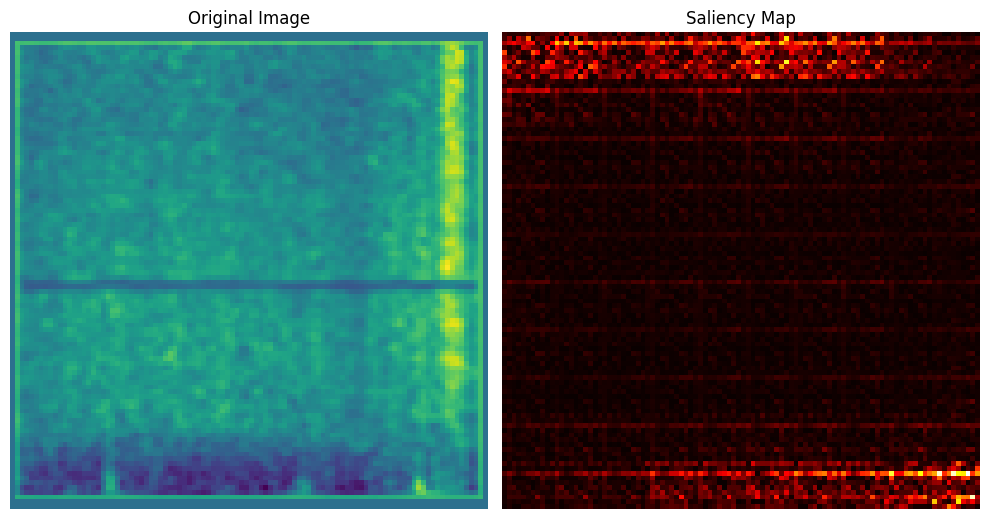

In [52]:
saliency(test_data_tensor[0],model)

<h1> ACTual 0 predicted 1

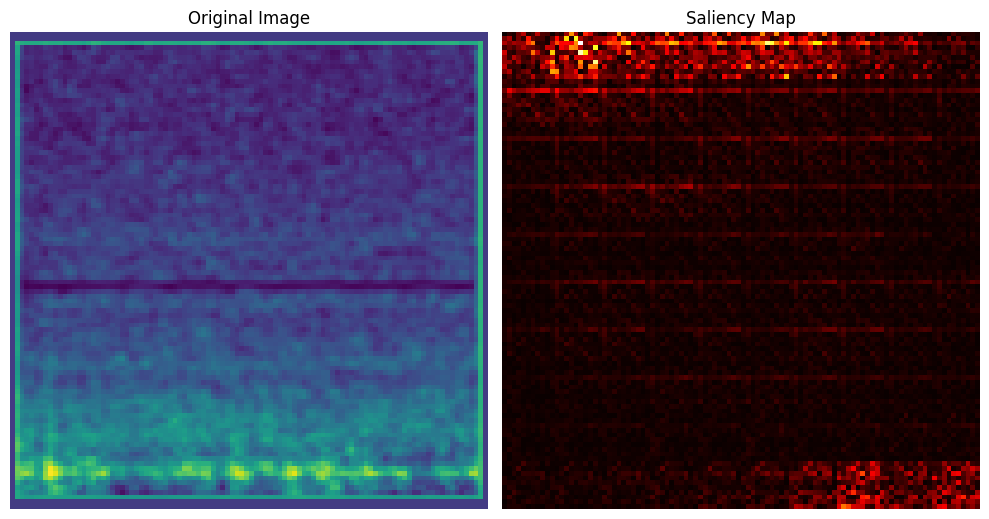

In [53]:
saliency(test_data_tensor[2],model)

<h1> ACtual 1 predicted 0

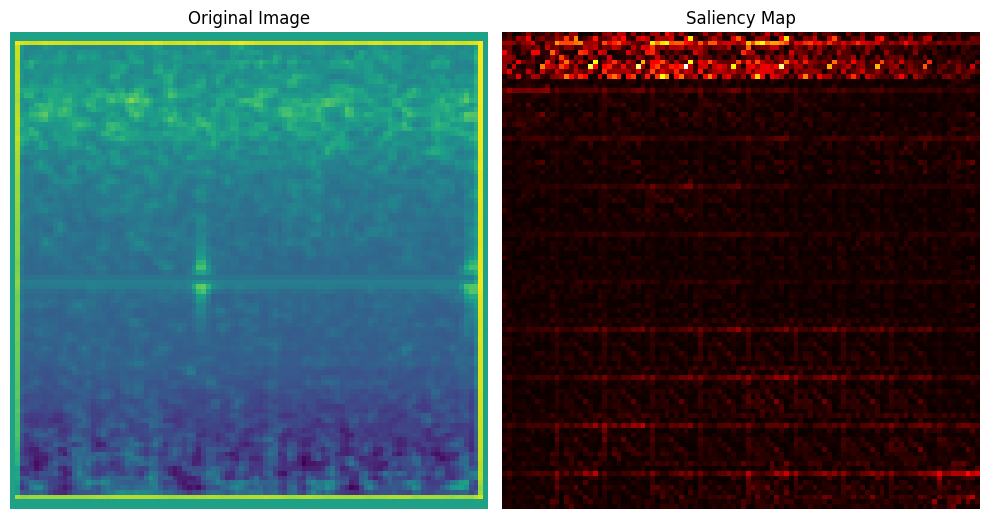

In [50]:
saliency(test_data_tensor[289],model)

<h1> ACtual 1 predicted 1

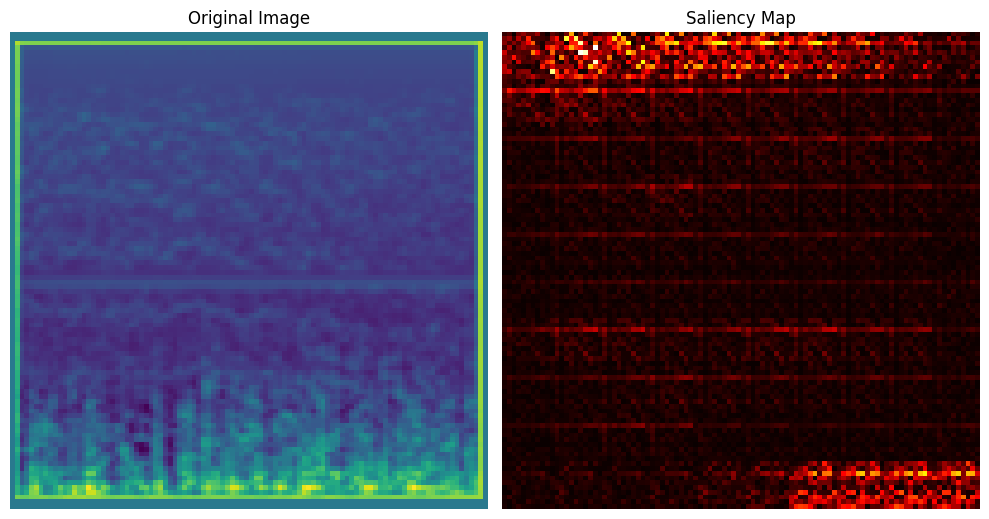

In [51]:
saliency(test_data_tensor[8],model)

<h1> TRYING TO AVERAGE THE RESULTS

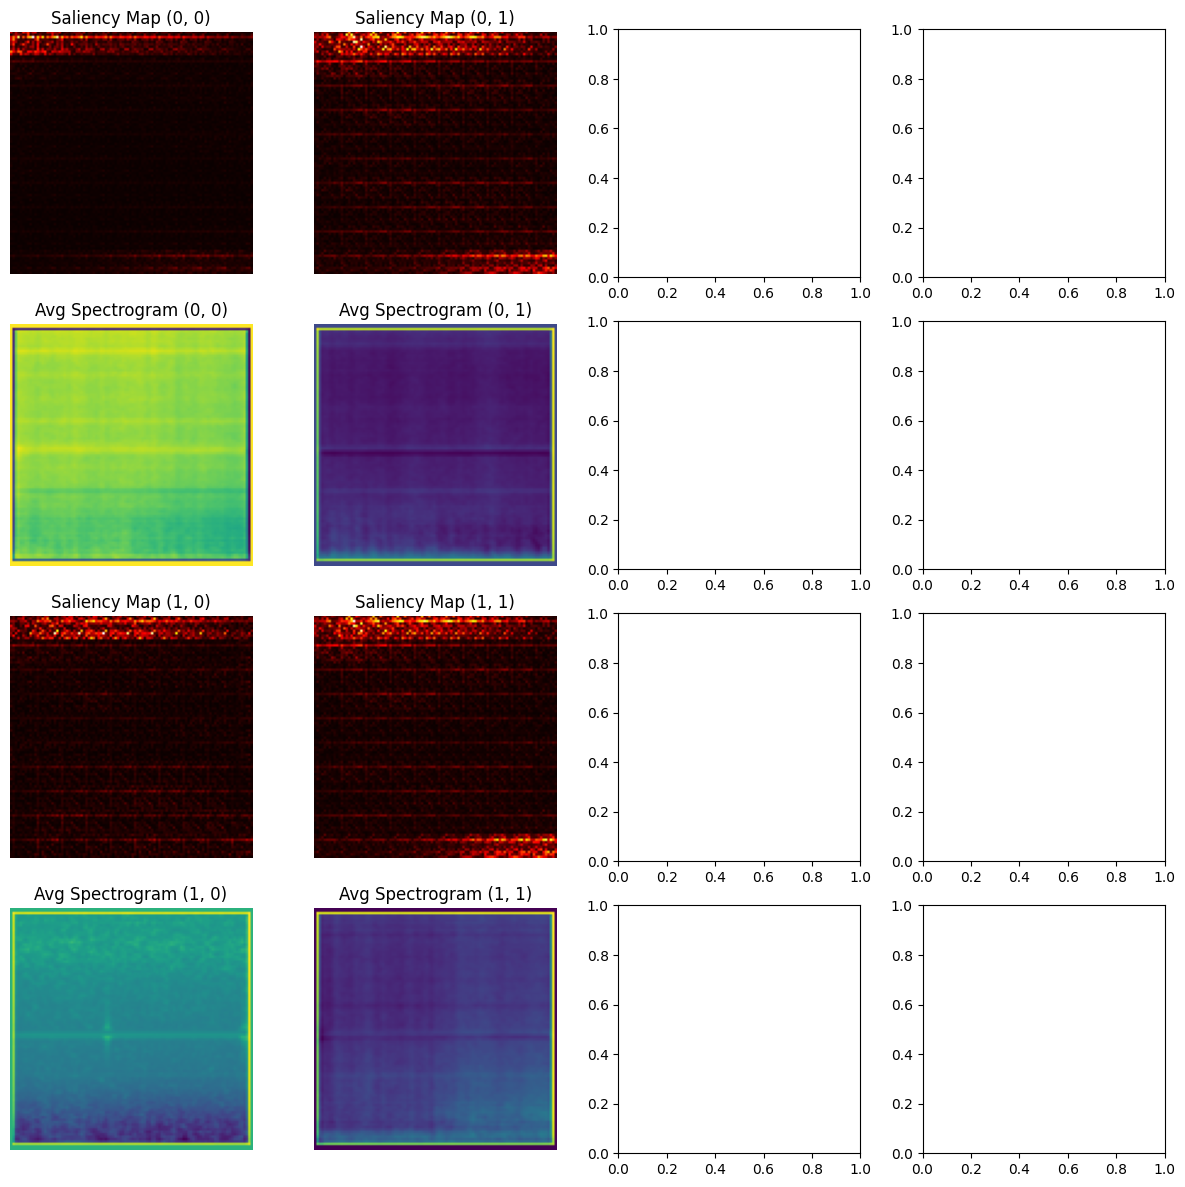

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def compute_saliency_maps_from_tensors(test_data_tensor, test_labels_tensor, model):
    """
    Computes averaged saliency maps for each category:
    - Class 0, Predicted 0
    - Class 0, Predicted 1
    - Class 1, Predicted 0
    - Class 1, Predicted 1
    """
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Containers for saliency maps grouped by (true_label, predicted_label)
    categories = {
        (0, 0): [],
        (0, 1): [],
        (1, 0): [],
        (1, 1): []
    }
    
    # Iterate over each image and label in the test set
    for img, true_label in zip(test_data_tensor, test_labels_tensor):
        img = img.unsqueeze(0)  # Add batch dimension
        img.requires_grad_(True)
        
        # Forward pass
        preds = model(img)
        predicted_label = torch.argmax(preds, dim=1).item()
        
        # Compute gradients for the predicted class
        score = preds[0, predicted_label]
        score.backward()
        
        # Compute saliency map
        saliency_map = torch.abs(img.grad[0].sum(dim=0))  # Sum over channels
        saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())  # Normalize
        
        # Add saliency map to the appropriate category
        categories[(true_label.item(), predicted_label)].append(saliency_map.detach().cpu().numpy())
        
        # Reset gradients
        model.zero_grad()
        img.grad.zero_()
    
    # Average saliency maps in each category
    averaged_maps = {}
    for key, saliency_maps in categories.items():
        if saliency_maps:
            averaged_maps[key] = np.mean(np.array(saliency_maps), axis=0)
        else:
            # Handle empty categories
            averaged_maps[key] = np.zeros_like(test_data_tensor[0][0].cpu().numpy())
    
    return averaged_maps

def plot_saliency_and_spectrograms(test_data_tensor, averaged_maps):
    """
    Plots the 2x2 grid of averaged saliency maps along with their spectrograms.
    """
    # Prepare the 2x2 grid
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    keys = [(0, 0), (0, 1), (1, 0), (1, 1)]
    
    for i, key in enumerate(keys):
        row = i // 2
        col = i % 2
        saliency_map = averaged_maps[key]
        
        # Plot the saliency map
        axes[row * 2, col].imshow(saliency_map, cmap='hot')
        axes[row * 2, col].set_title(f"Saliency Map {key}")
        axes[row * 2, col].axis('off')
        
        # Compute and plot the averaged spectrogram for the same category
        category_images = [
            np.mean(img.cpu().numpy(), axis=0) for img, true_label in zip(test_data_tensor, test_labels_tensor)
            if (true_label.item(), torch.argmax(model(img.unsqueeze(0)), dim=1).item()) == key
        ]
        
        if category_images:
            avg_spectrogram = np.mean(category_images, axis=0)
            axes[row * 2 + 1, col].imshow(avg_spectrogram, cmap='viridis')
            axes[row * 2 + 1, col].set_title(f"Avg Spectrogram {key}")
        else:
            axes[row * 2 + 1, col].set_title(f"No Data {key}")
        
        axes[row * 2 + 1, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
averaged_maps = compute_saliency_maps_from_tensors(test_data_tensor, test_labels_tensor, model)
plot_saliency_and_spectrograms(test_data_tensor, averaged_maps)


<h1> re-plotted to bigger images

In [58]:
plot_saliency_and_spectrograms(test_data_tensor, averaged_maps)